# Yield Estimation for Orchards - Vision Transformer Vs Well Established Approaches

## Introduction

## Related Work

## Approach

## The Dataset
- acfr-fruit-dataset

In [50]:
import os.path

import pandas as pd
from os import listdir
from tqdm import tqdm
def build_annotation_dataframe(path: str) -> pd.DataFrame:
    annotations = pd.DataFrame()
    for i, annotation in enumerate(tqdm(listdir(path))):
        part = pd.read_csv(os.path.join(path, annotation))
        part["picture_id"] = [annotation[:-4] for i in range(len(part))]
        part["picture_id"] = part["picture_id"].astype("string")
        if i == 0:
            annotations = part
            continue
        annotations = pd.concat([annotations,part])
    annotations.reset_index(inplace=True, drop=True)
    return annotations

In [58]:
dataset = {
    "almonds": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/almonds/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    },
    "apples": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/apples/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/apples/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    },
    "mangoes": {
        "global_df": build_annotation_dataframe(path="datasets/acfr-fruit-dataset/mangoes/annotations"),
        "train_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/train.txt", names=["picture_id"]).picture_id.astype("string"),
        "test_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/test.txt", names=["picture_id"]).picture_id.astype("string"),
        "val_ids": pd.read_csv("datasets/acfr-fruit-dataset/mangoes/sets/val.txt", names=["picture_id"]).picture_id.astype("string")
    }
}

100%|██████████| 1964/1964 [00:03<00:00, 506.64it/s]


In [162]:
dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id.isin(pd.read_csv("datasets/acfr-fruit-dataset/almonds/sets/train.txt", names=["picture_id"]).picture_id.astype("string"))]

,#item,x,y,dx,dy,label,picture_id
4,0,79.473684,271.052632,24.0,26.0,1,fromEast_58_54_IMG_4379_i2100j3000
5,1,82.105263,242.105263,24.0,26.0,1,fromEast_58_54_IMG_4379_i2100j3000
6,2,122.105263,219.473684,24.0,22.0,1,fromEast_58_54_IMG_4379_i2100j3000
7,3,135.263158,206.315789,26.0,24.0,1,fromEast_58_54_IMG_4379_i2100j3000
8,4,126.315789,148.421053,36.0,30.0,1,fromEast_58_54_IMG_4379_i2100j3000
...,...,...,...,...,...,...,...
4772,12,1.428571,86.666667,24.0,26.0,1,fromWest_61_18_IMG_4685_i1200j3300
4773,13,15.238095,174.761905,24.0,22.0,1,fromWest_61_18_IMG_4685_i1200j3300
4774,14,277.142857,87.619048,22.0,24.0,1,fromWest_61_18_IMG_4685_i1200j3300
4775,15,94.285714,76.190476,20.0,26.0,1,fromWest_61_18_IMG_4685_i1200j3300


In [163]:
print(f" Pictures without Annotations for Almonds: {len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/'))}")
print(f" Pictures without Annotations for Apples: {len(listdir('datasets/acfr-fruit-dataset/apples/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/apples/annotations/'))}")
print(f" Pictures without Annotations for Mangoes: {len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/')) - len(dataset['almonds']['global_df'].picture_id.unique())}, total number of pictures: {len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/'))}")

 Pictures without Annotations for Almonds: 48, total number of pictures: 620
 Pictures without Annotations for Apples: 548, total number of pictures: 1120
 Pictures without Annotations for Mangoes: 1392, total number of pictures: 1964


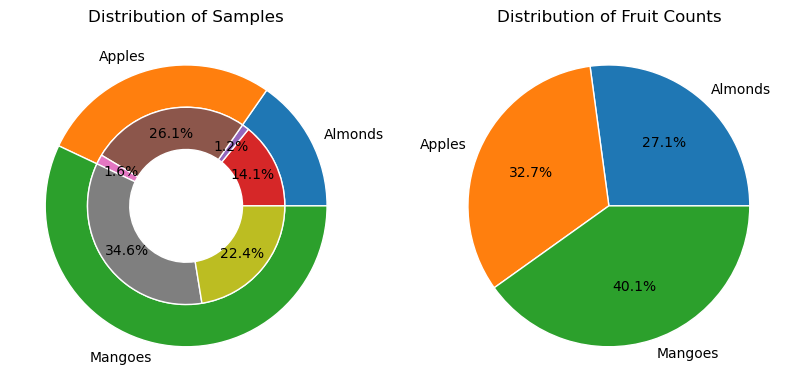

In [88]:
import matplotlib.pyplot as plt
import numpy as np
x_pictures = np.array([
    [len(dataset["almonds"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/almonds/annotations/')) - len(dataset["almonds"]["global_df"].picture_id.unique())],
    [len(dataset["apples"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/apples/annotations/')) - len(dataset["apples"]["global_df"].picture_id.unique())],
    [len(dataset["mangoes"]["global_df"].picture_id.unique()), len(listdir('datasets/acfr-fruit-dataset/mangoes/annotations/')) - len(dataset["apples"]["global_df"].picture_id.unique())]
])
x_fruits = [len(dataset["almonds"]["global_df"]), len(dataset["apples"]["global_df"]), len(dataset["mangoes"]["global_df"])]
labels = ["Almonds", "Apples", "Mangoes"]
size = 0.3
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pie(x_pictures.sum(axis=1), radius=1, labels=labels, wedgeprops=dict(width=0.3, edgecolor='w'))
ax[0].pie(x_pictures.flatten(), radius=1-size, autopct='%1.1f%%',wedgeprops=dict(width=0.3, edgecolor='w'), pctdistance=0.75)
ax[0].set_title("Distribution of Samples")
ax[1].pie(x_fruits, labels=labels, autopct='%1.1f%%', wedgeprops=(dict(edgecolor='w')))
ax[1].set_title("Distribution of Fruit Counts")
plt.show()

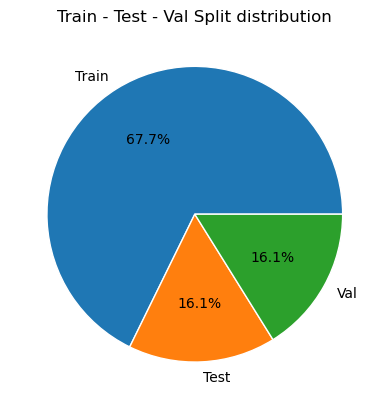

In [90]:
x = [len(dataset["almonds"]["train_ids"]), len(dataset["almonds"]["test_ids"]), len(dataset["almonds"]["val_ids"])]
plt.pie(x, labels=["Train", "Test", "Val"], autopct="%1.1f%%", wedgeprops=dict(edgecolor="w"))
plt.title("Train - Test - Val Split distribution")
plt.show()

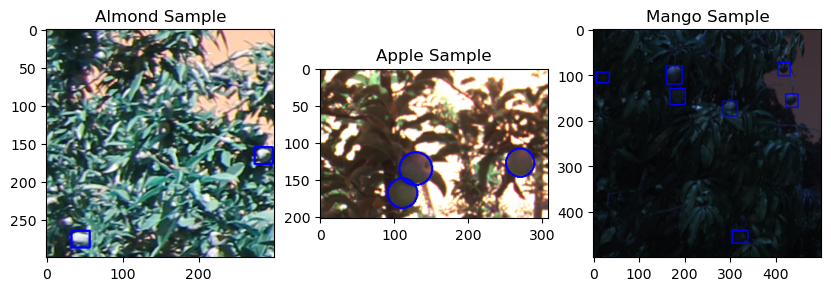

In [130]:
import cv2
almond_sample = pd.Series(dataset["almonds"]["global_df"].picture_id.unique()).sample(1)
apple_sample = pd.Series(dataset["apples"]["global_df"].picture_id.unique()).sample(1)
mangoes_sample = pd.Series(dataset["mangoes"]["global_df"].picture_id.unique()).sample(1)
almond_sample = dataset["almonds"]["global_df"].loc[dataset["almonds"]["global_df"].picture_id == almond_sample.item()]
apple_sample = dataset["apples"]["global_df"].loc[dataset["apples"]["global_df"].picture_id == apple_sample.item()]
mangoes_sample = dataset["mangoes"]["global_df"].loc[dataset["mangoes"]["global_df"].picture_id == mangoes_sample.item()]

# draw ROI on random almond sample
almond_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/almonds/images", f"{almond_sample.picture_id.iloc[0]}.png"))
almond_sample.reset_index(inplace=True, drop=True)
for idx, row in almond_sample.iterrows():
    cv2.rectangle(almond_sample_img, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(0,0,255), thickness=2)

# draw ROI on random apple sample
apple_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/apples/images", f"{apple_sample.picture_id.iloc[0]}.png"))
apple_sample.reset_index(inplace=True, drop=True)
for idx, row in apple_sample.iterrows():
    cv2.circle(apple_sample_img, (int(row["c-x"]), int(row["c-y"])), int(row.radius), color=(0,0,255), thickness=2)

# draw ROI on random mango example
mangoes_sample_img = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/mangoes/images", f"{mangoes_sample.picture_id.iloc[0]}.png"))
mangoes_sample.reset_index(inplace=True, drop=True)
for idx, row in mangoes_sample.iterrows():
    cv2.rectangle(mangoes_sample_img, (int(row.x), int(row.y)), (int(row.x) + int(row.dx), int(row.y) + int(row.dy)), color=(0,0,255), thickness=2)


fig, ax = plt.subplots(1,3, figsize=(10,8))
ax[0].imshow(almond_sample_img)
ax[0].set_title("Almond Sample")
ax[1].imshow(apple_sample_img)
ax[1].set_title("Apple Sample")
ax[2].imshow(mangoes_sample_img)
ax[2].set_title("Mango Sample")
plt.show()

In [152]:
apple_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/apples/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/apples/images", picture_name))
    apple_shapes["x"].append(pic.shape[1])
    apple_shapes["y"].append(pic.shape[0])
    apple_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    apple_shapes["picture_id"].append(picture_name[:-4])
    apple_shapes["mean"].append(pic.mean())
apple_shapes = pd.DataFrame(apple_shapes)

mango_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/mangoes/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/mangoes/images", picture_name))
    mango_shapes["x"].append(pic.shape[1])
    mango_shapes["y"].append(pic.shape[0])
    mango_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    mango_shapes["picture_id"].append(picture_name[:-4])
    mango_shapes["mean"].append(pic.mean())
mango_shapes = pd.DataFrame(mango_shapes)

almond_shapes = {
    "x": list(),
    "y": list(),
    "pixels": list(),
    "mean": list(),
    "picture_id": list()
}
for picture_name in tqdm(os.listdir("datasets/acfr-fruit-dataset/almonds/images")):
    pic = cv2.imread(os.path.join("datasets/acfr-fruit-dataset/almonds/images", picture_name))
    almond_shapes["x"].append(pic.shape[1])
    almond_shapes["y"].append(pic.shape[0])
    almond_shapes["pixels"].append(pic.shape[0] * pic.shape[1])
    almond_shapes["picture_id"].append(picture_name[:-4])
    almond_shapes["mean"].append(pic.mean())
almond_shapes = pd.DataFrame(almond_shapes)

apple_shapes

100%|██████████| 620/620 [00:02<00:00, 302.42it/s]


,x,y,pixels,mean,picture_id
0,308,202,62216,170.999845,20130320T004348.754118.Cam6_13
1,308,202,62216,140.663463,20130320T013350.339486_32
2,308,202,62216,66.595318,20130320T005957.154982.Cam6_51
3,308,202,62216,199.200238,20130320T005425.529158.Cam6_12
4,308,202,62216,117.436147,20130320T005448.577248.Cam6_22
...,...,...,...,...,...
1115,308,202,62216,188.879383,20130320T005444.386662.Cam6_21
1116,308,202,62216,171.005411,20130320T005108.382236.Cam6_11
1117,308,202,62216,43.294833,20130320T005452.005817.Cam6_63
1118,308,202,62216,178.287611,20130320T004908.951143.Cam6_23


In [153]:
variances = pd.DataFrame()
variances["apple_shapes"] = apple_shapes.var(numeric_only=True)
variances["almond_shapes"] = almond_shapes.var(numeric_only=True)
variances["mango_shapes"] = mango_shapes.var(numeric_only=True)
variances

,apple_shapes,almond_shapes,mango_shapes
x,0.000000,0.000000,3.232820e-27
y,0.000000,0.000000,3.232820e-27
pixels,0.000000,0.000000,8.474644e-22
mean,2461.866215,1128.139201,1.986331e+02


In [150]:
mango_shapes.x.unique(), mango_shapes.y.unique(), mango_shapes.pixels.unique() # Variance above comes from a library bottleneck, that pandas uses for faster calculation -> Numeric precision leads to rounding errors

(array([500]), array([500]), array([250000]))

Text(0.5, 1.0, 'Image Brightness')

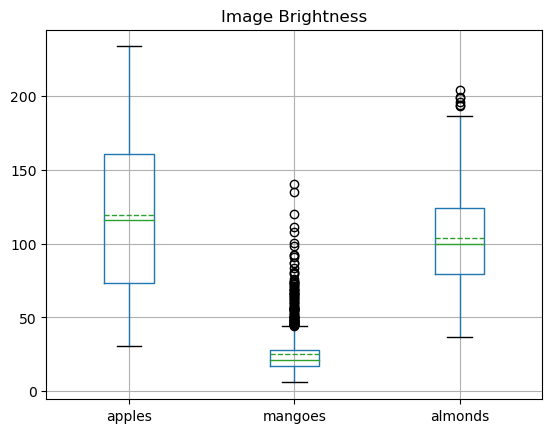

In [161]:
means = pd.DataFrame()
means["apples"] = apple_shapes["mean"]
means["mangoes"] = mango_shapes["mean"]
means["almonds"] = almond_shapes["mean"]
means.boxplot(showmeans=True, meanline=True)
plt.title("Image Brightness")

## Models

- Baseline: Faster R-CNN (Dataset Paper)
- ConvNext / ConvNextV2: Convolutional Neural Network inspired through VIT but with only Convolutional Modules
- YOLOV5
- YOLOS: You Only Look at One Sequence: Vision Transformer inspired by YOLO
- DETR: Vision Transformer with a Convolutional Backbone

## YOLOS

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/homebrew/Caskroom/miniconda/base/envs/industrialApplicationsOfAI/lib/python3.9/site-packages/transformers/models/yolos/image_processing_yolos.py:710: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Detected remote with confidence 0.994 at location [46.96, 72.61, 181.02, 119.73]
Detected remote with confidence 0.975 at location [340.66, 79.19, 372.59, 192.65]
Detected cat with confidence 0.984 at location [12.27, 54.25, 319.42, 470.99]
Detected remote with confidence 0.922 at location [41.66, 71.96, 178.7, 120.33]
Detected cat with confidence 0.914 at location [342.34, 21.48, 638.64, 372.46]


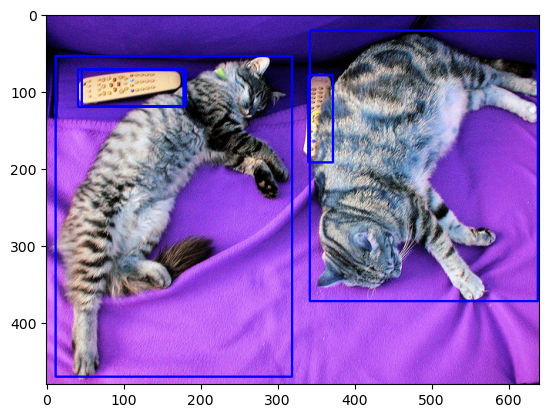

In [171]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {model.config.id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)
plt.imshow(image)

## DETR

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/opt/homebrew/Caskroom/miniconda/base/envs/industrialApplicationsOfAI/lib/python3.9/site-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


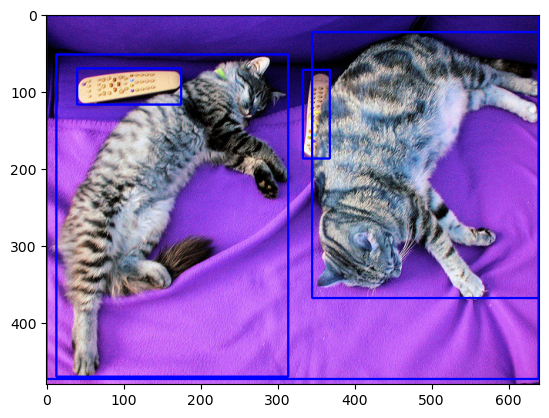

In [4]:
from transformers import AutoImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
     0
]

image = np.array(image)
image = image[:,:,::-1].copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
     box = [round(i, 2) for i in box.tolist()]
     print(
         f"Detected {model.config.id2label[label.item()]} with confidence "
         f"{round(score.item(), 3)} at location {box}"
     )
     cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(0,0,255), thickness=2)
plt.imshow(image)

## Evaluation

## Conclusion